## EvolAdversarial ##

This notebook runs the evolutionary adversarial examples from Nguyen et al. 2015 and performs some exploratory analysis on them.  Note that Nguyen et al. generate the images from Alexnet, and we are using VGG19.  In a way, the purpose of this notebook is to test the generalization of adversarial examples over relatively simple, yet state-of-the-art networks.  

In [1]:
import vgg19
import numpy as np
from urllib import urlretrieve
import gzip
import os
import matplotlib.pyplot as plt
import skimage.transform
from lasagne.utils import floatX



/afs/ir.stanford.edu/users/c/j/cjbillov/cs231n/project/CS231N-FinalProject/.env/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
% load_ext autoreload
% autoreload 1

In [3]:
import glob

def ensure_data_exists ():
    """ 
    Loads CPPN adversarial examples if they don't already exist.
    """
    filename = "fooling_images_5000_cppn.tar.gz"
    url = "http://www.evolvingai.org/share/fooling_images_5000_cppn.tar.gz"
    
    if not os.path.exists('../datasets/{0}'.format(filename)):
        print "Adversarial data set didn't exist, downloading..."
        urlretrieve(url, '../datasets/'+filename)
        print "Download complete."
        print 'unzipping...'
        !tar -xzvf ../datasets/fooling_images_5000_cppn.tar.gz
    else:
        print "found it!"
    

def read_image (img_file, mean_image):
#     try:
        im = plt.imread(img_file, '.png')

        h, w, _ = im.shape
        if h < w:
            im = skimage.transform.resize(im, (256, w*256/h), preserve_range=True)
        else:
            im = skimage.transform.resize(im, (h*256/w, 256), preserve_range=True)
            
        # Central crop to 224x224
        h, w, _ = im.shape
        im = im[h//2-112:h//2+112, w//2-112:w//2+112]
        rawim = np.copy(im).astype('uint8')

        # Shuffle axes to c01
        im = np.swapaxes(np.swapaxes(im, 1, 2), 0, 1)
    
        # Convert to BGR
        im = im[::-1, :, :]
        im = im - mean_image[:,None,None]
        print im.shape
        return rawim, floatX(im[None, :, :, :])
    

#     except:
#         # Abort
#         print "skipping link " + img_file
#         return None, np.zeros((1,))
    
def load_data (mean_image):
    """ 
    Import the evolutionary adversarial examples.  
    
    Returns:
    :images: a (N, C, H, W) tensor containing the validation dataset.
    :metadata: a list containing file metadata corresponding to each image.   
    """
    
    

    images = None
    metadata = []
    raw_im = np.zeros ((5000, 224, 224, 3), dtype=np.uint8)
    images = np.zeros ((5000, 3, 224, 224), dtype=np.float32)
    print images.shape
    i = 0
    
    for filename in glob.glob('../datasets/fooling/*.png'):

        print i, "looking at ", filename
        rawim, result = read_image (filename, mean_image)
        if result.any():
            images[i, :, :, :] = result 
            raw_im[i, :, :, :] = rawim[None, :, :, :] 
            i += 1 
        # read metadata
        file_info = filename.split('_')
        file_info[-1][:-4]
        data = {}

        data['index'] = i
        data['name'] = filename
        data['label'] = file_info[-2]
        data['confidence'] = float(file_info[-1][:-4]) # class confidence
        metadata.append(data)
        
    return raw_im, images, metadata



In [4]:
#ensure_data_exists()
import vgg19
import lasagne

net = vgg19.build_model()
classes, mean_image, values = vgg19.load_weights()
lasagne.layers.set_all_param_values(net['prob'], values)

In [5]:
raw_im, images, metadata = load_data(mean_image)

(5000, 3, 224, 224)
0 looking at  ../datasets/fooling/map_5000_978_0.69606179.png
(3, 224, 224)
1 looking at  ../datasets/fooling/map_5000_972_0.567023456.png
(3, 224, 224)
2 looking at  ../datasets/fooling/map_5000_3_0.42013669.png
(3, 224, 224)
3 looking at  ../datasets/fooling/map_5000_4_0.930807471.png
(3, 224, 224)
4 looking at  ../datasets/fooling/map_5000_970_0.899271011.png
(3, 224, 224)
5 looking at  ../datasets/fooling/map_5000_971_0.999993563.png
(3, 224, 224)
6 looking at  ../datasets/fooling/map_5000_7_0.965009332.png
(3, 224, 224)
7 looking at  ../datasets/fooling/map_5000_10_0.452454478.png
(3, 224, 224)
8 looking at  ../datasets/fooling/map_5000_964_0.933954954.png
(3, 224, 224)
9 looking at  ../datasets/fooling/map_5000_16_0.969205976.png
(3, 224, 224)
10 looking at  ../datasets/fooling/map_5000_17_0.937634826.png
(3, 224, 224)
11 looking at  ../datasets/fooling/map_5000_19_0.972607434.png
(3, 224, 224)
12 looking at  ../datasets/fooling/map_5000_20_0.289951801.png
(3,

In [6]:
from time import time

N = 9
%matplotlib inline
# test metadata

# store the predictions of vgg
predictions = []
QUANTA = 10


for j in np.arange(2000, 2000+N, QUANTA):
    t0 = time()
    sample = images[j:j+QUANTA, :, :, :]
    prob = np.array(lasagne.layers.get_output(net['prob'], 
                    sample, deterministic=True).eval())
    t1 = time()
    print "ran ex. {0} to {1} in {2} seconds".format(j, j + QUANTA, t1 - t0)
    y_predict = np.argmax(prob ,axis=1)
    print y_predict.shape, y_predict
    
    for i in xrange (QUANTA):
        res = {}
        res['label'] = classes[y_predict[i]]
        res['index'] = j + i
        res['confidence'] = prob[i, y_predict[i]]
        predictions.append(res)
    
    
# # run the VGG net

# #short_images = images[:10, :, :, :]

# #prob = np.array(lasagne.layers.get_output(net['prob'], short_images, deterministic=True).eval())

# for i in xrange(10):
#     print images[i].shape
#     plt.imshow(raw_im[i])
#     plt.axis('off')
#     plt.text(250, 70, 'Guess: {0} \nConfidence: {1}'.format(classes[ int(metadata[i]['label']) ], 
#                                                                metadata[i]['confidence']), fontsize=14)
#     plt.show()

ran ex. 2000 to 2010 in 36.8163781166 seconds
(10,) [528 769 845 494 904 842 905 905 577 806]


/afs/ir.stanford.edu/users/c/j/cjbillov/cs231n/project/CS231N-FinalProject/.env/local/lib/python2.7/site-packages/lasagne/layers/conv.py:489: UserWarning: The `image_shape` keyword argument to `tensor.nnet.conv2d` is deprecated, it has been renamed to `input_shape`.
  border_mode=border_mode)


In [7]:
print predictions


[{'index': 2000, 'confidence': 0.15553622725361338, 'label': 'dial telephone, dial phone'}, {'index': 2001, 'confidence': 0.8543252653462351, 'label': 'rule, ruler'}, {'index': 2002, 'confidence': 0.12836897345640058, 'label': 'syringe'}, {'index': 2003, 'confidence': 0.12018628407998713, 'label': 'chime, bell, gong'}, {'index': 2004, 'confidence': 0.15190971726064581, 'label': 'window screen'}, {'index': 2005, 'confidence': 0.22158291392748808, 'label': 'swimming trunks, bathing trunks'}, {'index': 2006, 'confidence': 0.49705027712327871, 'label': 'window shade'}, {'index': 2007, 'confidence': 0.75732063059141486, 'label': 'window shade'}, {'index': 2008, 'confidence': 0.35534430822222618, 'label': 'gong, tam-tam'}, {'index': 2009, 'confidence': 0.16001413159785322, 'label': 'sock'}]


In [6]:
# load the prediction data
import cPickle as pickle
with open('../datasets/cppn_results', 'r') as f:
    predictions = pickle.load(f)

In [28]:
# save the data

import cPickle as pickle

with open('../datasets/cppn_results', 'w+') as f:
    pickle.dump(predictions, f)

In [18]:
# Sort and Check status of data

predictions.sort(key=(lambda p: -metadata[p['index']]['confidence']))

print predictions
#print predictions



[{'index': 595, 'confidence': 0.0015380053687194313, 'label': 'gazelle'}, {'index': 2961, 'confidence': 0.0015355073565017892, 'label': 'gazelle'}, {'index': 4877, 'confidence': 0.0015514668671372835, 'label': 'gazelle'}, {'index': 3701, 'confidence': 0.0015869910638806519, 'label': 'coffee mug'}, {'index': 4248, 'confidence': 0.0013013704852983547, 'label': 'coffee mug'}, {'index': 4399, 'confidence': 0.0013733798130943222, 'label': 'gazelle'}, {'index': 1096, 'confidence': 0.0015978253126235273, 'label': 'gazelle'}, {'index': 2723, 'confidence': 0.0013942347629384052, 'label': 'coffee mug'}, {'index': 2115, 'confidence': 0.001420572704369768, 'label': 'gazelle'}, {'index': 4758, 'confidence': 0.0014811934977963625, 'label': 'coffee mug'}, {'index': 1174, 'confidence': 0.0013967262591546262, 'label': 'gazelle'}, {'index': 1304, 'confidence': 0.0014139760376597507, 'label': 'gazelle'}, {'index': 2518, 'confidence': 0.0014219693655641988, 'label': 'gazelle'}, {'index': 4642, 'confidence

In [8]:
# Run some statistics


highest_conf = max(predictions, key=lambda k:k['confidence'])
print highest_conf

# label variance

from collections import Counter

pred_frequency = Counter()
for elt in predictions:
    pred_frequency[ elt['label'] ] += 1

print pred_frequency

{'index': 2001, 'confidence': 0.8543252653462351, 'label': 'rule, ruler'}
Counter({'window shade': 2, 'dial telephone, dial phone': 1, 'sock': 1, 'window screen': 1, 'gong, tam-tam': 1, 'swimming trunks, bathing trunks': 1, 'syringe': 1, 'chime, bell, gong': 1, 'rule, ruler': 1})


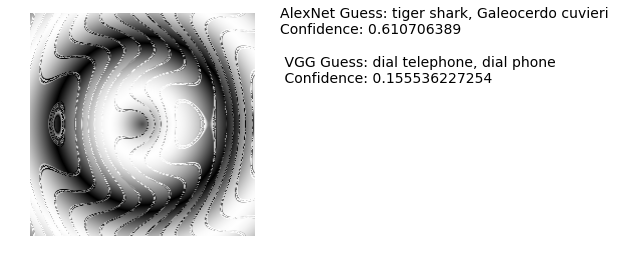

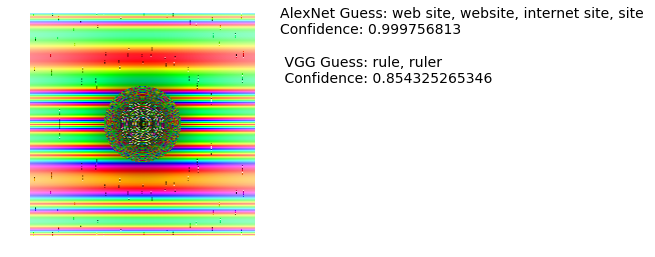

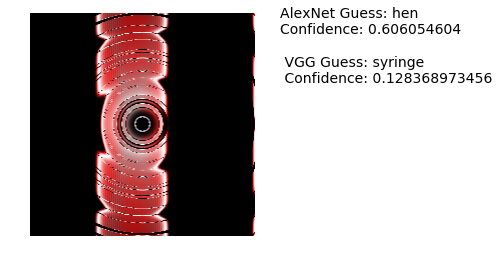

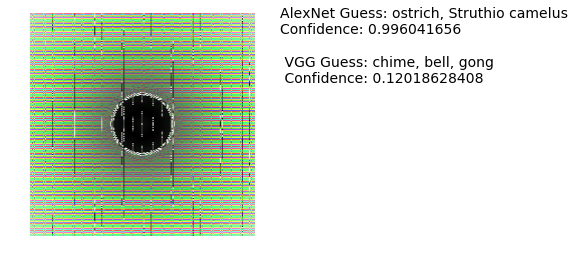

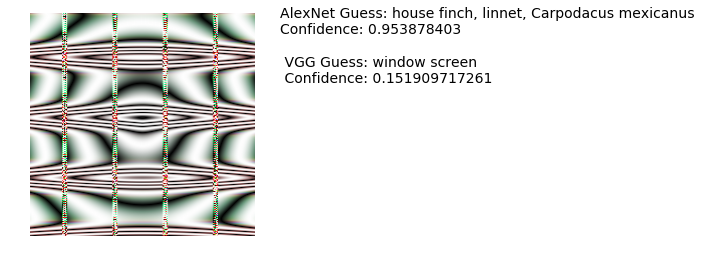

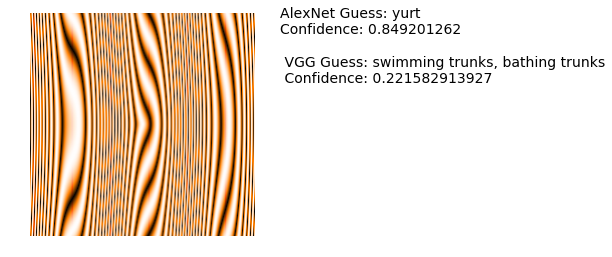

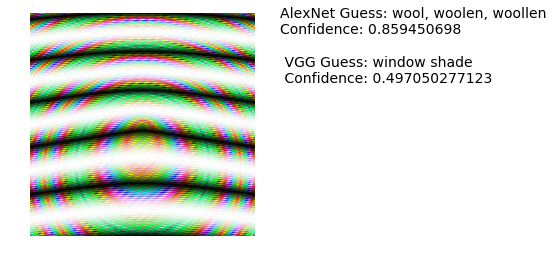

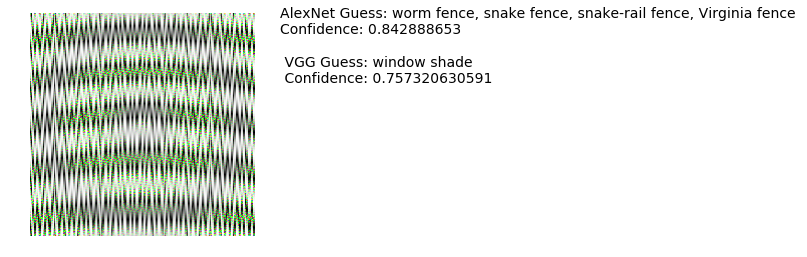

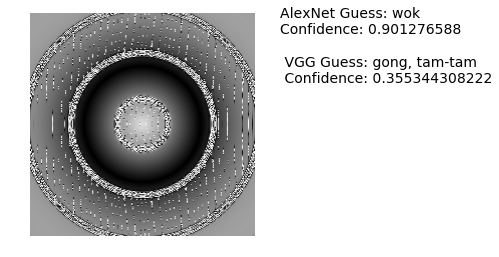

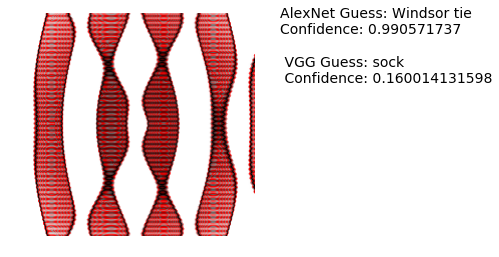

In [32]:
# print a random sample

num_examples = 10

indices = np.arange(2000, 2010)

for i in xrange(10):
    plt.imshow(raw_im[i+2000])
    plt.axis('off')
    plt.text(250, 70, 'AlexNet Guess: {0} \nConfidence: {1} \n\n VGG Guess: {2}\n Confidence: {3}'
             .format(classes[ int(metadata[i+2000]['label']) ], 
                     metadata[i+2000]['confidence'], predictions[i]['label'], predictions[i]['confidence']), 
                     fontsize=14)
    plt.show()


The maximum confidence VGG vested in any of the 5000 images that were evolved to fool AlexNet was ~0.17%, which indicates that of the images produced a uniform distribution over the classes (p = 0).  Further, we can see that the classes predicted are usually gazelle or coffee mug, which indicate a slight bias.

From this, we give the following remarks.


1a) Nguyen et al. investigate that adversarial examples generated for a given DNN are persistent across different initializations.  We have shown that DNN's with a different architecture are completely robust against adversarial examples generated for one architecture.

1b) Nguyen et al propose that some images evoke the predicted class, as some sort of artistic interpretation.  Such style is not a global quality learned about the image.  

2) Point 1 suggests that evolved adversarial examples have a similar "space of learning" representation to adversarial gradient ascent method than previously thought.  Specifically, evolved images might be a global version of local gradient ascent adversarial examples, and thus pose little threat in real-world applications, because they would be sensitive to ensembling.

3) In the literature, visualizations of the lower convolutional layers are similar for a wide variety of network designs.  Therefore, we should focus on middle to upper-layers to understand why different DNN's

4) Get money

2000
2001
2002
2003
2004
2005
2006
2007
2008
2009


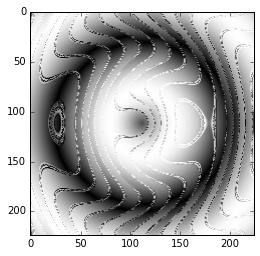

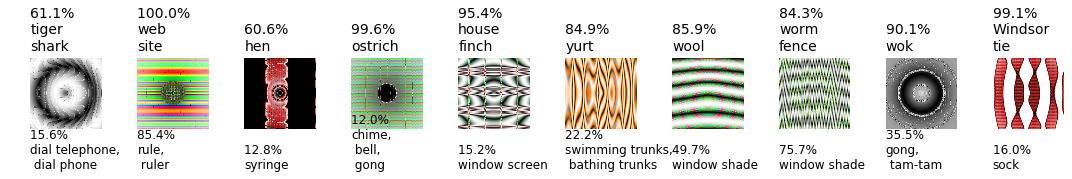

In [31]:
%matplotlib inline
num_examples = 10

indices = np.arange(2000, 2010)

plt.imshow(raw_im[2000])

f, plot = plt.subplots(1, 10, figsize=(15, 4))
plt.axis('off')

count = 0
for index in indices:
    
    x, y = count / 5, count % 5
    
    print index
    i = index - 2000
    
    label = classes[ int(metadata[index]['label'] )]
    if  ',' in label:
        shortened_label = label[:label.index(',')]
    else:
        shortened_label = label
    shortened_label = '\n'.join(shortened_label.split(' '))
    
    plot[count].text(0, -25, "{0:.1f}% \n{1}".format(100 * metadata[index]['confidence'], 
                     shortened_label),
                     fontsize=14)
    plot[count].imshow(raw_im[index])
    plot[count].axis('off')
    
    
    vgg_label = ',\n'.join(predictions[i]['label'].split(','))
    
    plot[count].text(0, 350, "{0:.1f}% \n{1}".format(100 * predictions[i]['confidence'], 
                     vgg_label),
                     fontsize=12)
    
    count += 1
#     plt.axis('off')
#     plt.text(250, 70, 'AlexNet Guess: {0} \nConfidence: {1} \n\n VGG Guess: {2}\n Confidence: {3}'
#              .format(classes[ int(metadata[i]['label']) ], 
#                      metadata[i]['confidence'], predictions[i]['label'], predictions[i]['confidence']), 
#                      fontsize=14)
   # plt.show()
plt.tight_layout()
plt.savefig('adversarial.png', dpi=300)
plt.show()